In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("InsuranceClaimsEDA") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/12 14:44:07 WARN Utils: Your hostname, MacBook-Air-Maryna.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.142 instead (on interface en0)
25/11/12 14:44:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/12 14:44:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path = "../data/raw/insurance_claims_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
df.printSchema()
df.show(5)

root
 |-- policy_id: string (nullable = true)
 |-- subscription_length: double (nullable = true)
 |-- vehicle_age: double (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- region_code: string (nullable = true)
 |-- region_density: integer (nullable = true)
 |-- segment: string (nullable = true)
 |-- model: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- max_torque: string (nullable = true)
 |-- max_power: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- airbags: integer (nullable = true)
 |-- is_esc: string (nullable = true)
 |-- is_adjustable_steering: string (nullable = true)
 |-- is_tpms: string (nullable = true)
 |-- is_parking_sensors: string (nullable = true)
 |-- is_parking_camera: string (nullable = true)
 |-- rear_brakes_type: string (nullable = true)
 |-- displacement: integer (nullable = true)
 |-- cylinder: integer (nullable = true)
 |-- transmission_type: string (nullable = true)
 |-- steering_type: string (n

25/11/12 14:44:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
row = df.count()
cols = len(df.columns)
unique_rows = df.distinct().count()
print(f"Number of rows: {row}", f"Number of columns: {cols}", f"Number of unique rows: {unique_rows}", sep="\n")

Number of rows: 58592
Number of columns: 41
Number of unique rows: 58592


In [6]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'policy_id': 0,
 'subscription_length': 0,
 'vehicle_age': 0,
 'customer_age': 0,
 'region_code': 0,
 'region_density': 0,
 'segment': 0,
 'model': 0,
 'fuel_type': 0,
 'max_torque': 0,
 'max_power': 0,
 'engine_type': 0,
 'airbags': 0,
 'is_esc': 0,
 'is_adjustable_steering': 0,
 'is_tpms': 0,
 'is_parking_sensors': 0,
 'is_parking_camera': 0,
 'rear_brakes_type': 0,
 'displacement': 0,
 'cylinder': 0,
 'transmission_type': 0,
 'steering_type': 0,
 'turning_radius': 0,
 'length': 0,
 'width': 0,
 'gross_weight': 0,
 'is_front_fog_lights': 0,
 'is_rear_window_wiper': 0,
 'is_rear_window_washer': 0,
 'is_rear_window_defogger': 0,
 'is_brake_assist': 0,
 'is_power_door_locks': 0,
 'is_central_locking': 0,
 'is_power_steering': 0,
 'is_driver_seat_height_adjustable': 0,
 'is_day_night_rear_view_mirror': 0,
 'is_ecw': 0,
 'is_speed_alert': 0,
 'ncap_rating': 0,
 'claim_status': 0}

In [7]:
cat_cols = ["region_code", "segment", "model", "fuel_type", "engine_type", "rear_brakes_type", "transmission_type", "steering_type"]
for col in cat_cols:
    df.select(col).distinct().show()

+-----------+
|region_code|
+-----------+
|         C6|
|        C22|
|        C21|
|        C18|
|         C3|
|         C4|
|        C11|
|        C12|
|        C14|
|        C20|
|         C5|
|         C9|
|        C16|
|         C8|
|        C13|
|         C1|
|         C2|
|        C15|
|         C7|
|        C17|
+-----------+
only showing top 20 rows
+-------+
|segment|
+-------+
|     B2|
|     B1|
|      A|
|Utility|
|     C1|
|     C2|
+-------+

+-----+
|model|
+-----+
|   M4|
|   M7|
|   M6|
|  M11|
|   M1|
|   M5|
|   M2|
|   M3|
|  M10|
|   M9|
|   M8|
+-----+

+---------+
|fuel_type|
+---------+
|   Diesel|
|      CNG|
|   Petrol|
+---------+

+--------------------+
|         engine_type|
+--------------------+
|  1.2 L K12N Dualjet|
|                G12B|
|   K Series Dual jet|
|1.5 Turbocharged ...|
|       1.5 L U2 CRDi|
|1.2 L K Series En...|
|              i-DTEC|
|             1.0 SCe|
|                K10C|
|   F8D Petrol Engine|
|1.5 Turbocharged ...|
+---------

+------------+
|claim_status|
+------------+
|           1|
|           0|
+------------+



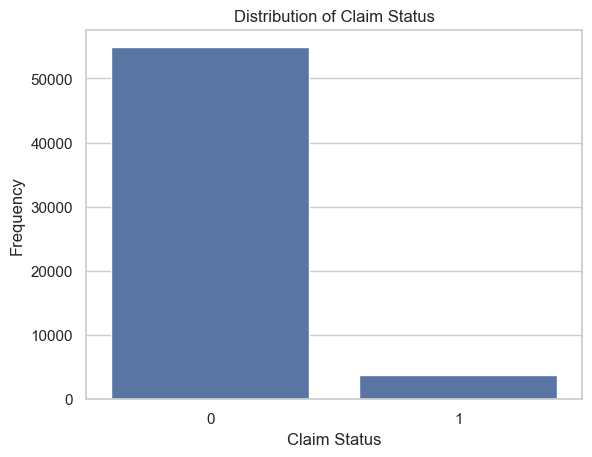

In [8]:
df.select("claim_status").distinct().show()
sns.set_theme(style="whitegrid")
sns.countplot(data=df.toPandas(), x="claim_status", fill=True)
plt.title("Distribution of Claim Status")
plt.xlabel("Claim Status")
plt.ylabel("Frequency")
plt.show()

In [9]:
pandas_df = df.toPandas()
pandas_df['claim_status'].value_counts(normalize=True)

claim_status
0    0.936032
1    0.063968
Name: proportion, dtype: float64

In [10]:
num_cols = ["subscription_length", "vehicle_age", "customer_age", "region_density", "airbags", "displacement", "cylinder", "turning_radius", "length", "width", "gross_weight", "ncap_rating"]
df[num_cols].describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|subscription_length|       vehicle_age|      customer_age|    region_density|           airbags|      displacement|           cylinder|     turning_radius|            length|             width|      gross_weight|       ncap_rating|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|  count|              58592|             58592|             58592|             58592|             58592|             58592|              58592|              58592|             58592|             58592|             58592|             58592|
|   mean|  6.111687602403046|1.38847

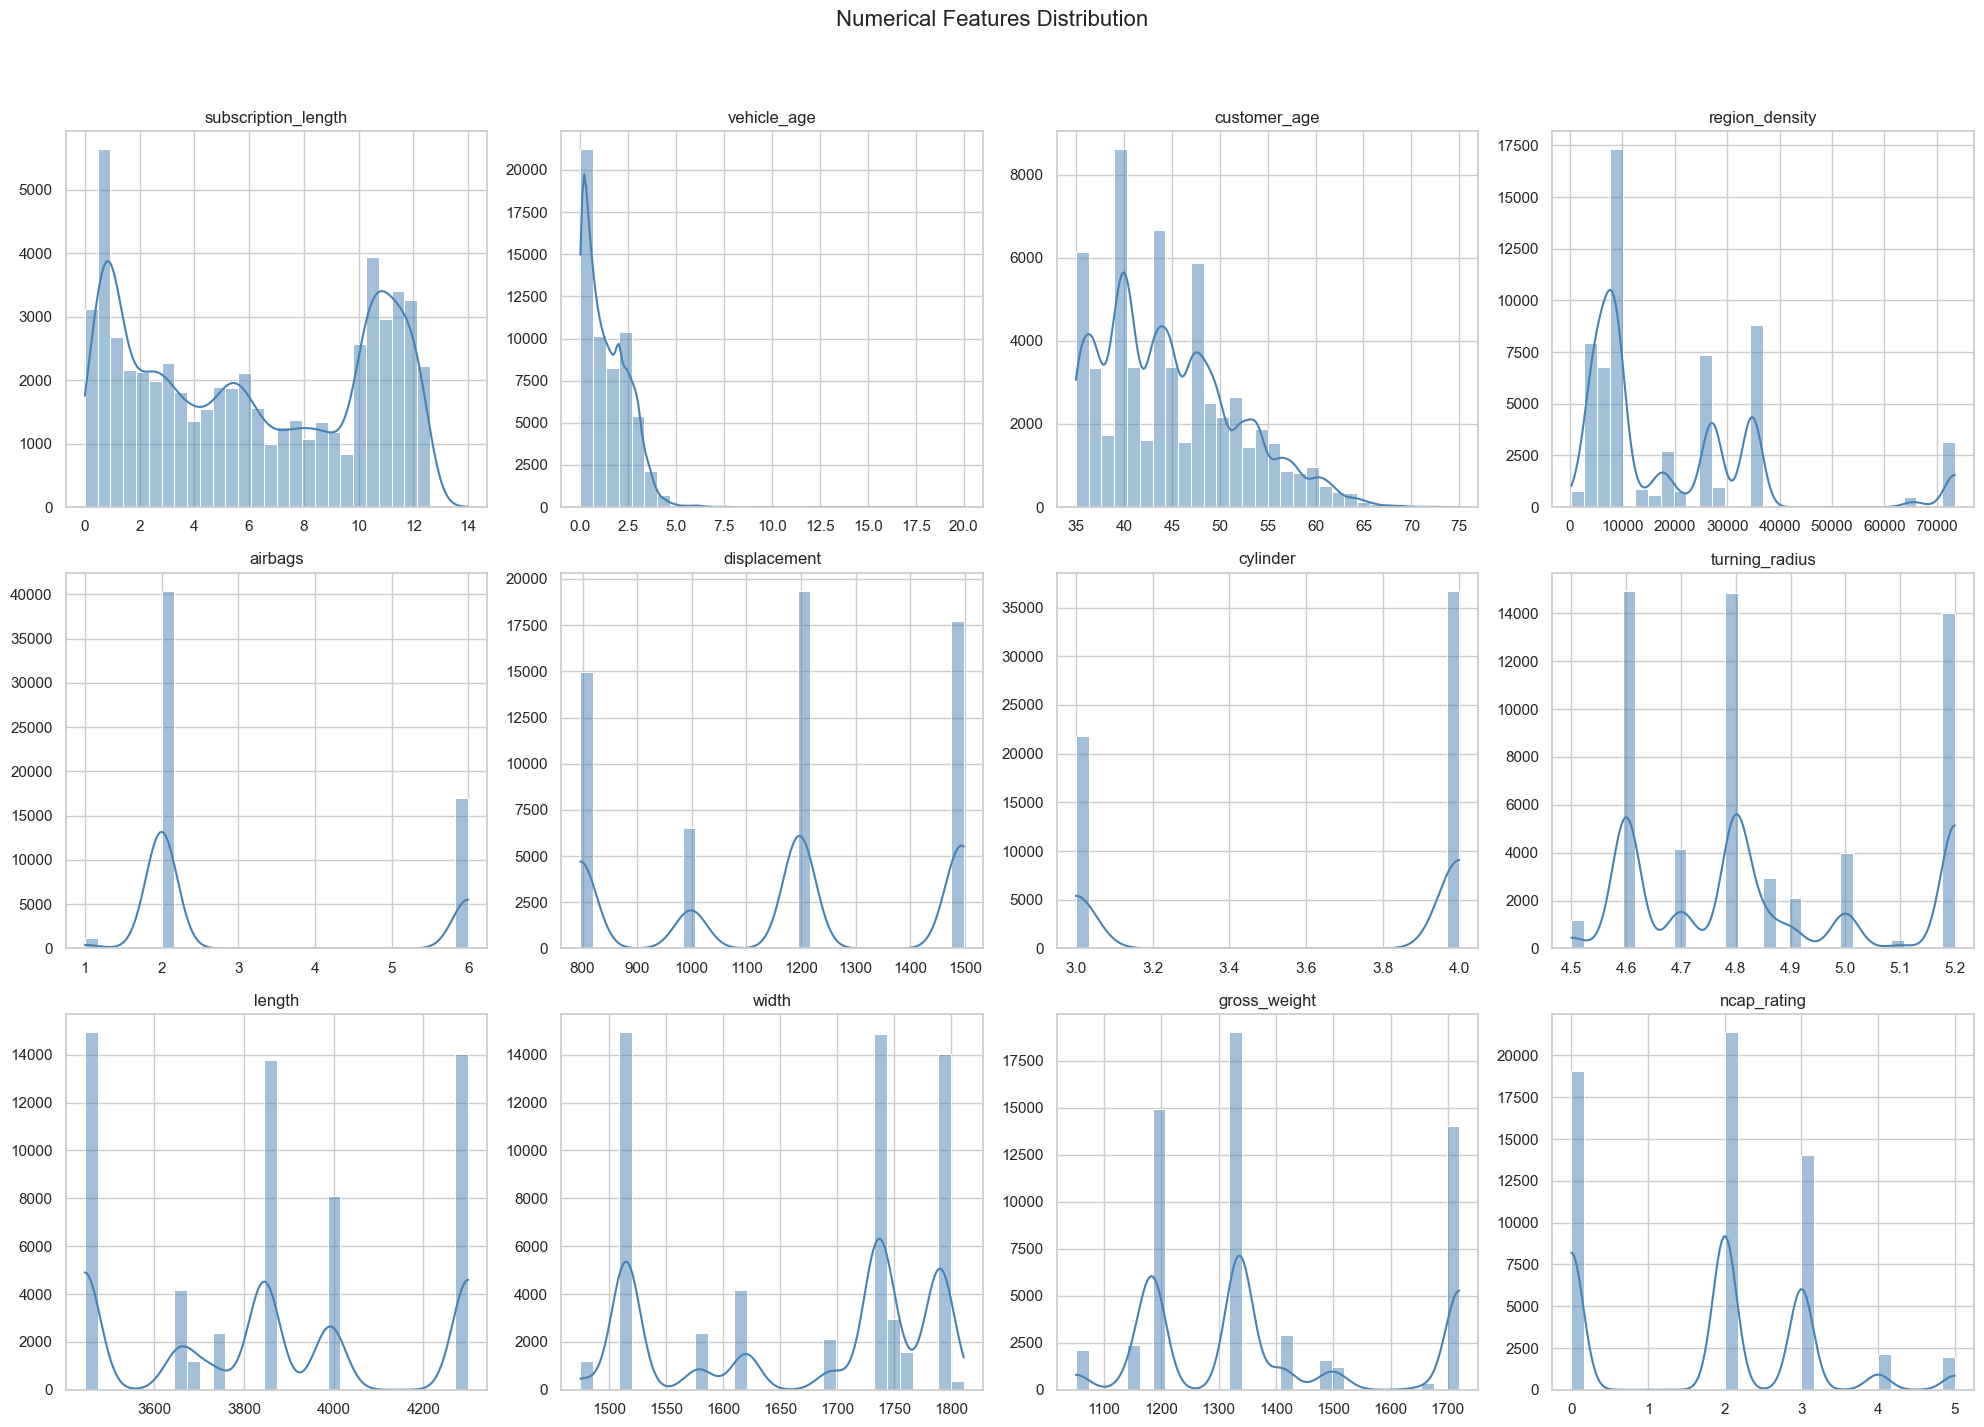

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(data=pandas_df, x=col, kde=True, ax=axes[i], bins=30, color="steelblue")
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numerical Features Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
spark.stop()

### 01_EDA Summary & Next Steps

**Summary of Findings:**
- Dataset contains **58,592 rows and 41 columns**, all with valid values.
- **No missing data** detected.
- **Target variable (`claim_status`)** is highly imbalanced (≈6% claims).
- **Numeric features** show right-skewed and multimodal distributions.
- **Some columns** (like `max_torque`, `max_power`) need numeric extraction.
- **Several variables** (`ncap_rating`, `airbags`, `cylinder`) behave like categorical.
- **Possible multicollinearity** in size-related features (`length`, `width`, `gross_weight`).

**Next Steps:**
- Proceed to `02_data_preprocessing`:
  - Fix data types and extract numeric values from mixed columns.
  - Encode categorical and binary variables.
  - Save cleaned dataset for modeling and deeper EDA.
